<a href="https://colab.research.google.com/github/skander-kerkeni/Captioning/blob/main/Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<font size=15 color='992208'><center>Livrable 3 - Groupe 2</center></font> 
<center>Gwendal Lupart - Skander Kerkeni - Charles Semard - Grégory Hue</center>

Ce livrable concerne la dernière étape du traitement requis. L'objectif est de créer un réseau de neurones qui génère des légendes pour des photographies, en s'appuyant sur le dataset MS COCO. Le réseau sera composé de deux parties, la partie CNN qui encode les images en une représentation interne, et la partie RNN qui utilise cette représentation pour prédire l'annotation séquence par séquence. Avant l'entraînement du modèle, les images sont prétraitées par un CNN pré-entrainé pour la classification.

## 0. Workflow

Le workflow de ce projet est séparé en 3 grandes parties.
- Classification : il s'agit de déterminer si une image est une photo ou non.
- Denoising : parmi toutes les photos, certaines sont de mauvaise qualité, la partie denoising consiste à améliorer la qualité de ces images.
- Captioning : l'objectif de cette partie est de légender chaque image par une phrase descriptive de l'image.

La classification commence par un dataset séparé en 5 classes : Photo, Peinture, Texte, Schéma et Dessins. Nous avons remanipulé manuellement ce dataset pour obtenir un dataset avec 2 classes : Photo et Non-photo, la classe Non-photo regroupe Peinture, Texte, Schéma et Dessin. Notre dataset est séparé en training et test. Nous utilisons un CNN de type VGG-16. Ce VGG-16 a été pré-entrainé sur ImageNet, possède une fonction d'optimisation Adam, une fonction de perte BinaryCrossEntropy, et une fonction d'activation ReLU. On utilise par ailleurs un early stopping pour l'entrainement. Ce modèle nous permet ensuite de différencier les image "photo" des images "non-photo".

Désormais, dans la partie Denoising, notre dataset contient uniquement des photos, certaines de mauvais qualité. Pour résoudre ce problème, nous allons volontairement ajouter du bruit sur la totalité de notre dataset. Notre modèle est un autoencoder pré-entrainé sur ImageNet, avec un fonction d'optimisation Adam, une fonction de perte MSE et une fonctione d'activation ELU. Encore une fois, nous utilisons l'early stopping pour l'entrainement. L'autoencoder reconsistu correctement les images bruitées.

Enfin pour la partie Captioning, notre dataset contient des photos de bonne qualité. Pour légender les photos, nous allons redimensionner nos photos à l'aide de l'inceptionV3 pré-entrainé sur ImageNet d'un côté et utiliser la classe Tokenizer sur un dataset d'annotation d'un autre côté. Ceci notre permettra d'obtenir un dictionnaire sous la forme {chemin_image:annotation}. Par la suite, nous allons utiliser un CNN et un RNN. Le CNN va redimensionner les images pour les adapter au RNN, puis le RNN va prédire mot à mot les annotations, tout en gardant en mémoire les mots précédents.


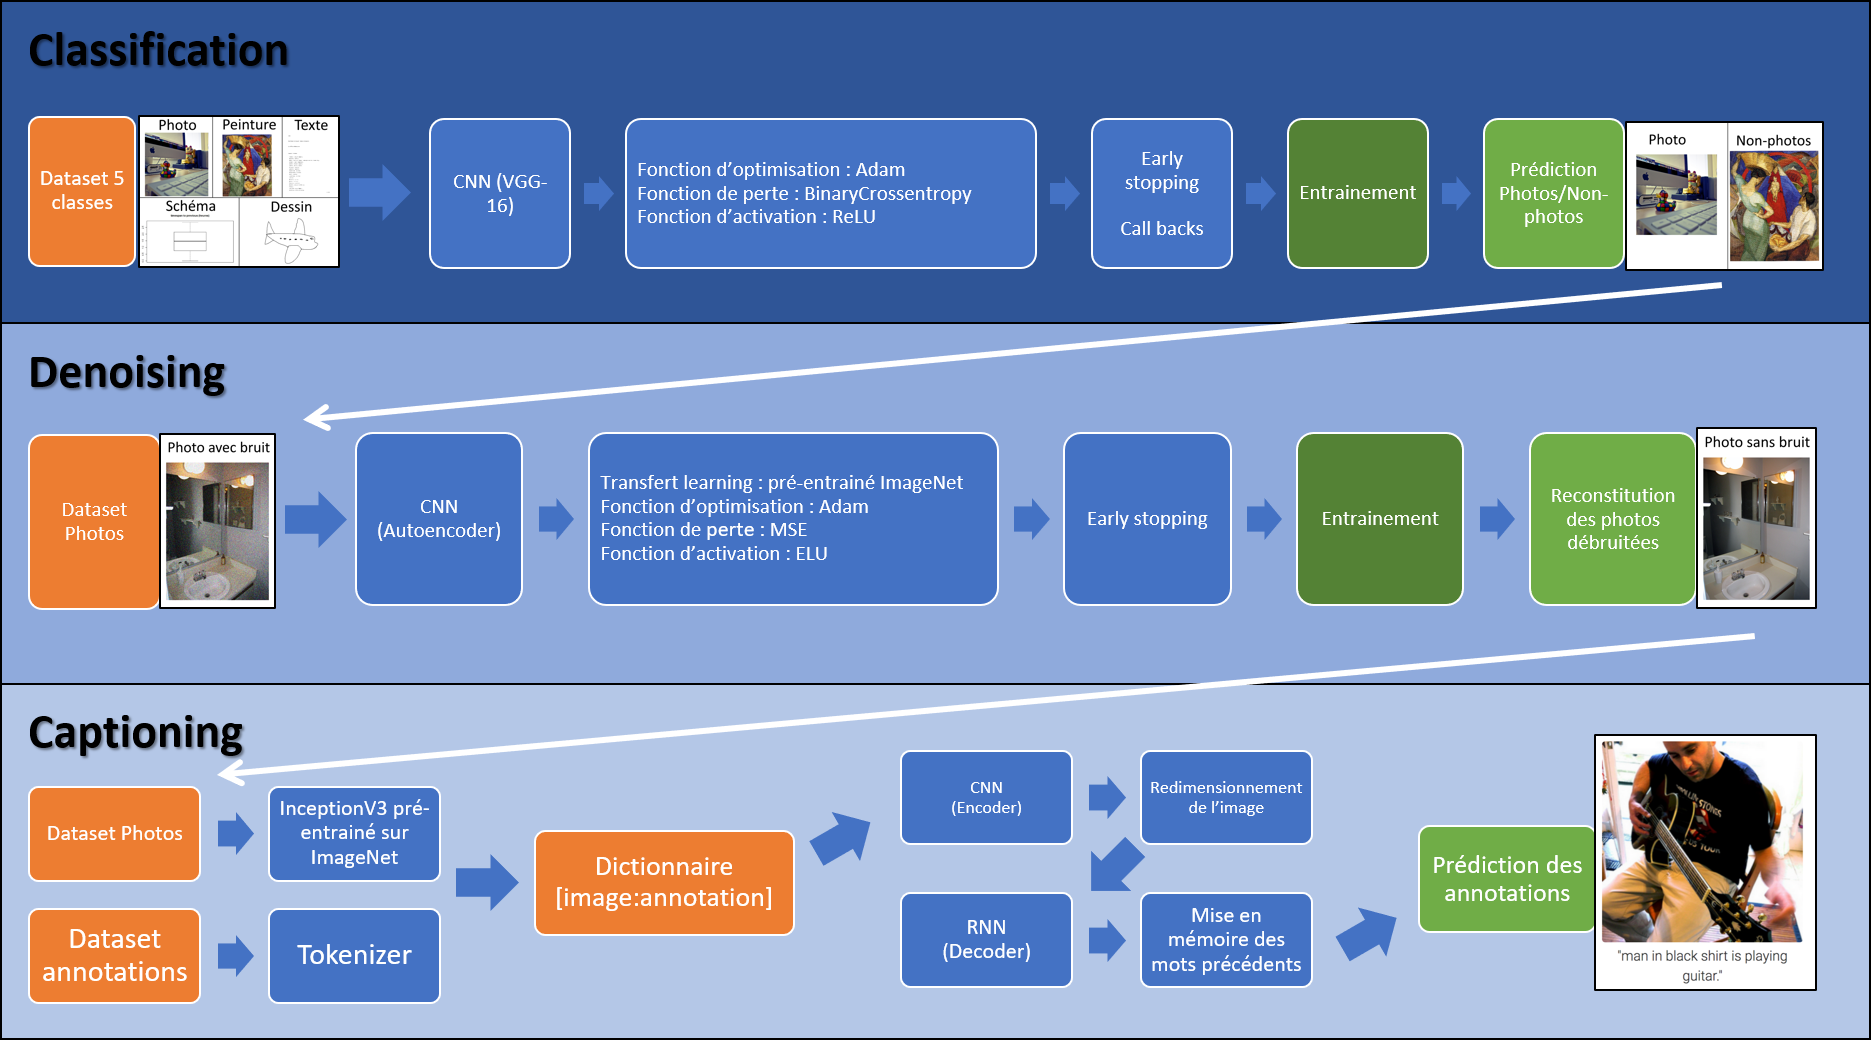


##1. Importation des bibliothèques & des datasets

**Importation des bibliothèques**

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

<b>Chargement des données et pré-traitement des annotations</b>

In [ ]:
# Téléchargement des fichiers d'annotation
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Téléchargement des image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:    
    # marquer le debut et la fin de chaque annotation
    caption =  f"<start> {val['caption']} <end>"
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)
    
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:2000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    for i in range(len(caption_list)):
        img_name_vector.append(image_path)


13510582272/13510573713 [==============================] - 407s 0us/step


## 2. Pré-traitement des données

**Récupération du modèle InceptionV3 pré-entraîné avec la classification sur le dataset ImageNet**

Inception v3 est un CNN dont l'objectif est d'utiliser moins de puissance de calcul que ces prédécesseurs. Son architecture est large, aussi il nécessite de comprendre que le réseau utilise :
- Des convolutions factorisées qui réduisent le nombre de paramètres dans le réseau, et vérifie son efficacité.
- Des convolutions plus petites pour un entrainement plus rapide. Par exemple un filtre de 5 x 5 peut être réduit en 2 filtre de 3 x 3, faisant passer de 25 paramètres à 18.
- Des convolutions asymétriques, par exemple une convolution de 3 x 3 peut être remplacé par deux convolutions de 1 x 3 puis 3 x 1.
- Des Classificateurs auxiliaires, ce sont des CNN de tailles réduites insérés entre couches pendant l'entrainement. Cela sert de régularisateur.

L'Inception v3 prend en entrée des images de 299 x 299 x 3 et produit en sortie des images de 8 x 8 x 2048. Le modèle contient des convolutions, des pooling moyens, des pooling maximaux, concaténations et des couches fully connected. La perte est calculée à l'aide de Softmax.
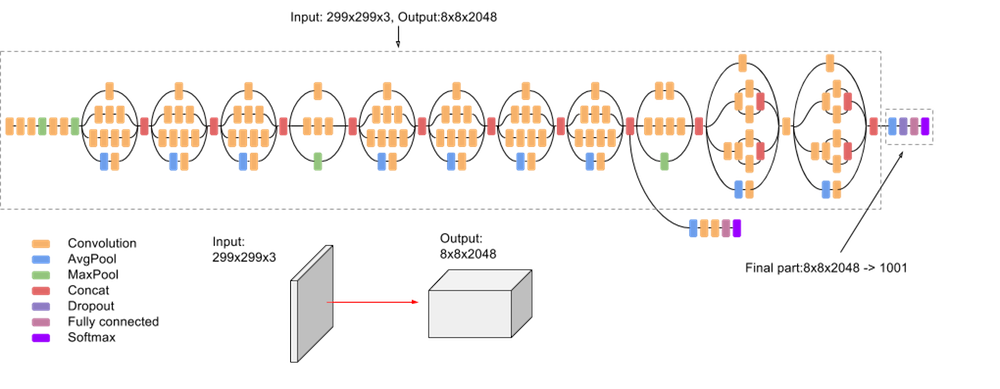


In [ ]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input =  image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer =  image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model =  tf.keras.Model(new_input, hidden_layer)

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img, image_path

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

87924736/87910968 [==============================] - 1s 0us/step


100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


**Tokenization**

Pour annoter les images, il est nécessaire de passer par un processus de *tokenisation*. Il s'agit là de séparer un texte en plusieurs parties significatives qu'on appelle un *token*. 

Concrètement, ce que fait la classe Tokenizer, c'est de prendre une phrase, la séparer en chaque mot et attributer un jeton à chaque mot puis transforme le mot en vecteur, pour rendre ce dernier exploitable. Par ailleurs, il remplit chaque vecteur jusqu'à la longueur maximale des annotations, afin d'avoir une taille fixe.

In [ ]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)

# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs =  tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector =  tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

## 3. Formation du jeu d'entrainement et de test 
On sépare le dataset en deux parties : 

*   Un jeu d'entrainement (80%)
*   Un jeu de test (20%)

Le code qui effectue ces opérations est détaillé dans la cellule suivante.

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotations
# Les images sont dupliquées car il y a plusieurs annotations par image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Création des datasets de formation et de validation en utilisant 
un fractionnement 80-20 de manière aléatoire
""" 
# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

# Diviser des indices en entrainement et test
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

"""
Les jeux d'entrainement et de tests sont sous forme
de listes contenants les mappings :(image prétraitée ---> jeton d'annotation(mot) )
"""

# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    # Duplication des images en le nombre d'annotations par image
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

10005 10005


(8005, 8005, 2000, 2000)

Création d’un jeu de données d’entrainement représenté par une instance [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) partant du jeu de données de base (les noms des fichiers et des annotations du jeu d’entrainement). La classe `tf.data.Dataset` sert à représenter des jeu de données volumineux et facilitent les prétraitements de ceux-ci.

In [ ]:
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# On mélange les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## 4. Le modèle 

Par rapport au modèle, la dernière couche convolutive d'`InceptionV3` est de la forme `(8, 8, 2048)`. Ce vecteur a été remodelé en la forme `(64, 2048)` lors du stockage au niveau du disque. Ce vecteur est ensuite passé à travers l'encodeur CNN (qui se compose d'une seule couche entièrement connectée). Le RNN s'occupera de prédire pour ce vecteur le mot suivant dans l'annotation. [L'image](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb) ci-dessous reprend un exemple d'une architecture très basique d'un système d'annotation utilisant un CNN et un RNN.


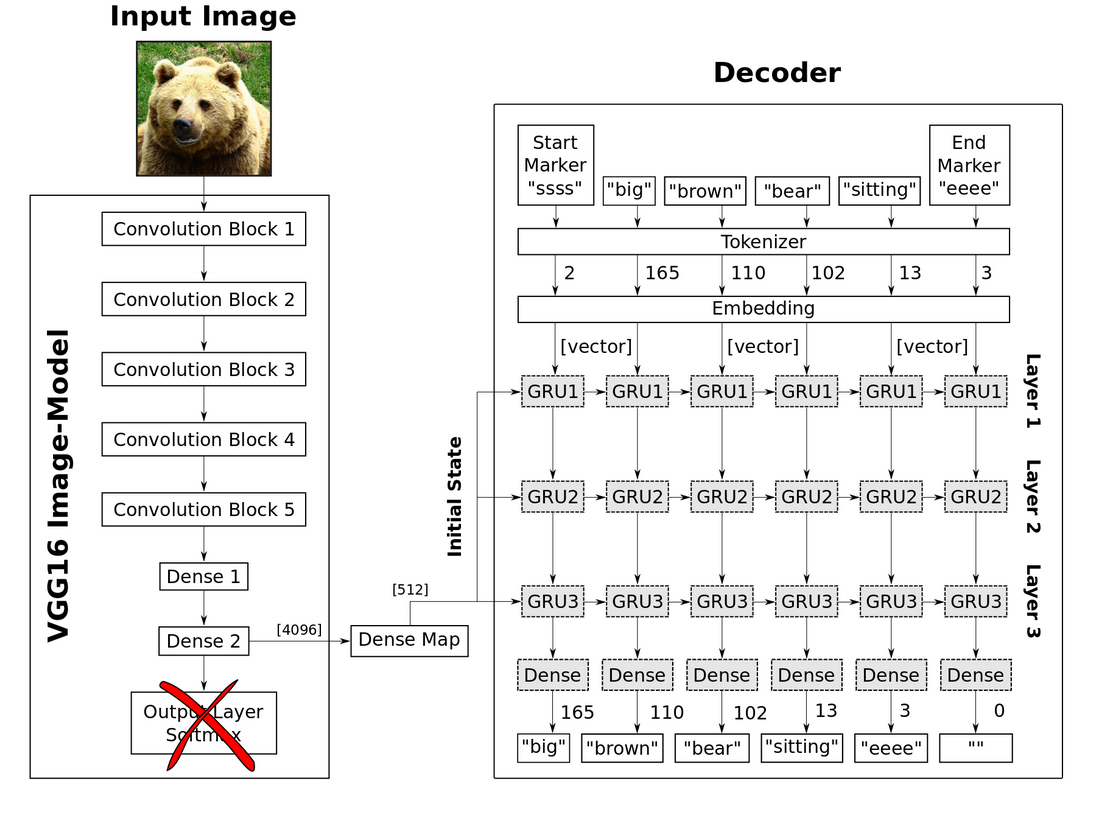

Dans cet exemple le captioning se fait de cette façon:
<ul>
    <li>L'image est passée à travers le CNN pour avoir une représentation compacte de celui-ci. Cette représentation est retournée par la couche `Dense 2` de taille 4096.</li>
    <li>Cette représentation est réduite en la passant à la couche dense `Dense Map` pour être mise en entrée comme état caché initial aux cellules du RNN.</li>
    <li>La partie RNN est composée de <a href="https://openclassrooms.com">GRU</a> (Gated Reccurent Unit). Cette partie est constituée de 3 couches. Une couche représentant de manière assez sommaire un niveau d'abstraction du langage. </li>
    <li>Le RNN a en entrée l'annotation ainsi que l'image en forme compacte, et retourne pour chaque colonne le mot suivant le mot en entrée au niveau de la colonne.</li>
    <li>Les annotations sont représentées en liste de mot. Cette liste est inexploitable par le RNN, elle est donc passée à un module qui remplace chaque mot par un entier (ou jeton entier), puis par un autre module qui projette chaque jeton en un vecteur dont les éléments sont entre -1 et 1.</li>
</ul>

Notre système d'annotation suivra de manière assez globale le même principe que montré dans l'image ci-dessous, néanmoins il contiendra des différences essentielles le distinguant de cet exemple. La système contiendra, notamment, un mécanisme d'attention dont la fonction est d'amener le réseau de neurones à donner une plus grande importance dans ses prédictions de l'annotation aux parties de l'images les plus parlantes et les plus pertinentes.

**L'encodeur CNN :**

L'encodeur CNN produit une représentation adéquate de l'image qu'il transmet au décodeur RNN pour la légender. Le CNN a en entrée les caractéristiques des images déjà prétraitées par InceptionV3 et stockées sur disque.

Ces images ont été remodelées pour avoir la taille 64x2048. Cela signifie que cette représentation contient pour chacune des 64 positions de l’image prétraitée les 2048 caractéristiques extraites par InceptionV3. Et donc, l’entrée du décodeur CNN est un batch ou chaque élément est constitué des 2048 caractéristiques des 64 positions de l’image prétraitée (qui était à l’origine 8x8). La couche dense qui suit calcule une nouvelle représentation de l’image de taille 64x256 ou chaque position de l’image a donc 256 caractéristiques. Les poids sont les mêmes pour les neurones de mêmes position qui se trouvent sur la même colonne dans l’image prétraitée (qui sont associées à la même caractéristique de l’image). Ceci provient de la manière qu’a la couche dense de gérer les opérations matricielles dans tensorflow.

L’avantage de cette représentation par rapport à la représentation aplatie est de préserver de l’information spatiale au niveau des couches du réseau de neurones. Ceci permettra au mécanisme d’attention de la partie RNN de détecter les positions intéressantes au niveau de l’image et de renseigner l’algorithme sur quelle zone il devra porter le plus d’importance pour légender l’image.

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

**Le mécanisme d'attention :**

Le mécanisme d’attention ressemble beaucoup à une cellule [RNN classique]( https://fr.wikipedia.org/wiki/R%C3%A9seau_de_neurones_r%C3%A9currents), mais avec quelques différences. La partie de l’attention a en entrée la représentation de l’image prétraitée retournée par le CNN ainsi que la valeur courante de l’état cachée du GRU, et en sortie le **vecteur du contexte** qui reflète les caractéristiques les plus importantes de l’image. Une étape intermédiaire pour calculer ce vecteur consiste à calculer les **poids d’attention** qui représentent l’importance de chaque position de l’image (il y en a 64) dans la prédiction de son annotation.

La représentation de l’image donnée en entrée est transformée au début de la même manière que pour le CNN en la passant à une couche dense de taille `units`. De même, l’état caché est aussi passé à une couche dense de taille `units`. La nouvelle représentation de l’image est ensuite additionnée à l’état caché puis passée à une fonction d’activation de type [`tanh`](https://fr.wikipedia.org/wiki/Tangente_hyperbolique) comme pour les cellules classiques de RNN. À ce niveau-là, on aura une représentation des données de taille `64xunits` contenant un mélange d’informations sur l’image et sur le texte de l’annotation. Un score est ensuite associé à chacune des positions en passant cette représentation à une couche dense. Ces scores sont normalisés avec une couche softmax pour produire le vecteur des **poids d’attention**. 

Finalement, chaque caractéristique de la représentation de l’image en entrée sera multipliée (pondérée) par le vecteur d’attention. Après quoi, on prend la somme de chaque caractéristique le long des positions (les lignes de la représentation) pour former le **vecteur du contexte**.

De façon globale, on peut dire que le vecteur d’attention dépend de scores qui sont appris à partir d’une représentation spatiale et textuelle de l’image. Ce vecteur d’attention renvoie la pertinence de chaque position et sert à calculer le vecteur du contexte qui nous donnera l’importance des caractéristiques de l’image.


In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))


        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

**Architecture décodeur RNN**

Le but du décodeur RNN est d'utiliser l'image en entrée renvoyée par le CNN, et de prédire l'annotation de l'image, mot par mot.

Le RNN est composé d'une cellule GRU qui possède un état caché qui contient la mémoire des derniers éléments vu par le GRU. Il met à jour son état avant de le retourner.
Lors de l'exécution du RNN, le mot actuel, la représentation de l'image et l'état caché du GRU sont donnés en entrée du RNN. Les mots sont représentés par des entiers, il faut donc utiliser une couche embedding pour obtenir à la place un représentation vectorielle.
Un mécanisme d'attention permet d'obtenir un vecteur qui décrit les caractéristiques dominantes de l'image. Il est calculé grâce aux caractéristiques de l’image encodées par le CNN ainsi que l’état caché du GRU qui résume l’historique des mots. Par la suite, le mot actuel et le contexte sont concaténés pour former une nouvelle fois le vecteur d'entrée du GRU.

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        #Couche dense qui aura pour entrée la sortie du GRU
        self.fc1 = tf.keras.layers.Dense(self.units)
        # Dernière couche dense
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # L'attention est defini par un modèle a part
        context_vector, attention_weights = self.attention(features, hidden)
        # Passage du mot courant à la couche embedding
        x = self.embedding(x)

        # Concaténation
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passage du vecteur concaténé à la gru
        output, state = self.gru(x)
        
        # Couche dense
        y = self.fc1(output)

        y = tf.reshape(y, (-1, x.shape[2]))
        
        # Couche dense
        y = self.fc2(y)
        
        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)

# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [ ]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()

# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

Pour garder la trace de notre apprentissage on utilise la classe train.checkpoint.

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

On initialise l'époque de début d’entrainement dans `start_epoch`. La classe `tf.train.Checkpoint` permet de poursuivre l’entrainement là ou on l’a laissé s’il avait été interrompu auparavant.

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

##  5. Entrainement et test
On implémente ensuite les fonctions `train_step` et `evaluate` :

- La fonction `train_step` représente une étape de l'entrainement du réseau. Elle est composée de l'évaluation par l'encodeur du vecteur pré-calculé par InceptionV3. La sortie de cette étape sera transmise au décodeur qui se charge de prédire l'annotation mot par mot. La boucle pour prédire chaque mot et calculer la perte associée devra être implémentée dans cette fonction.
- La fonction `evaluate` servira à évaluer les performances du réseau sur le jeu de test. Elle est donc similaire à la fonction `train_step` sauf que la partie calcul de la fonction de perte est absente car il n'agit pas d'entrainer le réseau.</li>





**Entraînement**
<br />
La fonction qui permet d'achever une étape d'entrainement sur un batch d'images est `train_step`. La fonction a en entrée un batch d'images prétraitées ainsi que leurs annotations et retourne la perte associée à ce batch. 

L'état caché de la partie RNN est initialisé ainsi que le mot de départ avec le token de début. Les caractéristiques de l'image sont ensuite extraites par l’encodeur. Après cela, on parcourt le batch mot par mot pour prédire le mot suivant à l'aide du décodeur. Le décodeur utilise l'état caché, les caractéristiques de l'image ainsi que le mot précédent pour prédire le mot courant. Le décodeur met à jour l'état caché et le retourne ainsi que les prédictions du batch. La perte est calculée à partir des prédictions retournées par le décodeur et les annotations associées au batch.

Finalement, la perte globale ainsi que le gradient sont calculés et le réseau est mis à jour.

In [ ]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Le code global contenant la boucle d'entrainement est présenté ci-dessous. Cette boucle parcours le jeu de données d'entrainement batch par batch et entraine le réseaux avec ceux-ci.

Epoch 9 Batch 0 Loss 6.1351
Epoch 9 Loss 4.132591
Time taken for 1 epoch 62.418338775634766 sec

Epoch 10 Batch 0 Loss 2.2878
Epoch 10 Loss 2.338939
Time taken for 1 epoch 2.952819585800171 sec

Epoch 11 Batch 0 Loss 1.9936
Epoch 11 Loss 2.171529
Time taken for 1 epoch 3.2404096126556396 sec

Epoch 12 Batch 0 Loss 1.7752
Epoch 12 Loss 1.976556
Time taken for 1 epoch 2.6273345947265625 sec

Epoch 13 Batch 0 Loss 1.7668
Epoch 13 Loss 1.798942
Time taken for 1 epoch 2.5142691135406494 sec

Epoch 14 Batch 0 Loss 1.5236
Epoch 14 Loss 1.638239
Time taken for 1 epoch 2.604182004928589 sec

Epoch 15 Batch 0 Loss 1.4257
Epoch 15 Loss 1.491472
Time taken for 1 epoch 2.742511749267578 sec

Epoch 16 Batch 0 Loss 1.2340
Epoch 16 Loss 1.341320
Time taken for 1 epoch 3.143771171569824 sec

Epoch 17 Batch 0 Loss 1.0824
Epoch 17 Loss 1.183083
Time taken for 1 epoch 2.5531809329986572 sec

Epoch 18 Batch 0 Loss 1.0424
Epoch 18 Loss 1.048741
Time taken for 1 epoch 2.635413646697998 sec

Epoch 19 Batch 0 

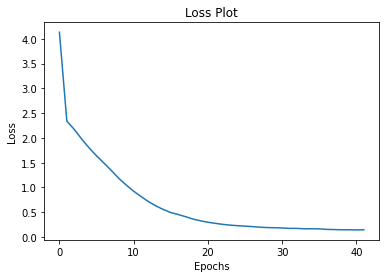

In [ ]:
"""
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # sauvegarde de la perte
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Affichage de la courbe d'entrainement
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()
"""


La fonction qui permet d'achever une étape d'evaluation pour le test est dans la cellule suivante. 

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## 6. Evaluation des performances

Pour évaluer les performances de notre modèle nous avons utilisé l'algorithme d'évaluation BLEU.


D'après Kishore Papineni, et al. in their 2002 paper “*BLEU: a Method for Automatic Evaluation of Machine Translation*“,

BLEU (bilingual evaluation understudy) est un algorithme d’évaluation de la qualité du texte. La qualité est considérée comme la correspondance entre la production d’une machine et celle d’un humain : « plus une traduction automatique est proche d’une traduction humaine professionnelle, mieux c’est ».
La sortie de BLEU est toujours un nombre compris entre 0 et 1, qui indique dans quelle mesure le texte candidat est similaire aux textes de référence, les valeurs plus proches de 1 représentant des textes plus similaires. Peu de traductions humaines atteindront une note de 1, car cela indiquerait que le candidat est identique à l’une des traductions de référence. Pour cette raison, il n’est pas nécessaire d’obtenir un score de 1.

L'exemple suivant n'est pas représentatif des performances de notre modèle.

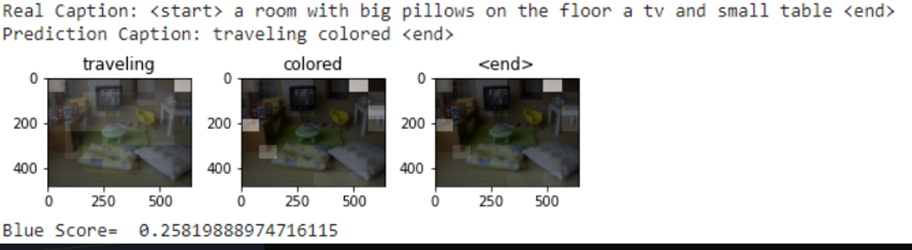

Comme on peut le voir ci-dessus, l'annotation est imprécise, le blue score est de 0.26. Pour un résultat avec une annotation précise, le score se rapprochera de 1.

## 7. Prédictions

**Tester le modéle sur une seule image**

Real Caption: <start> a woman is going to bake something with cheese in a kitchen <end>
Prediction Caption: a man standing in a very clean kitchen <end>


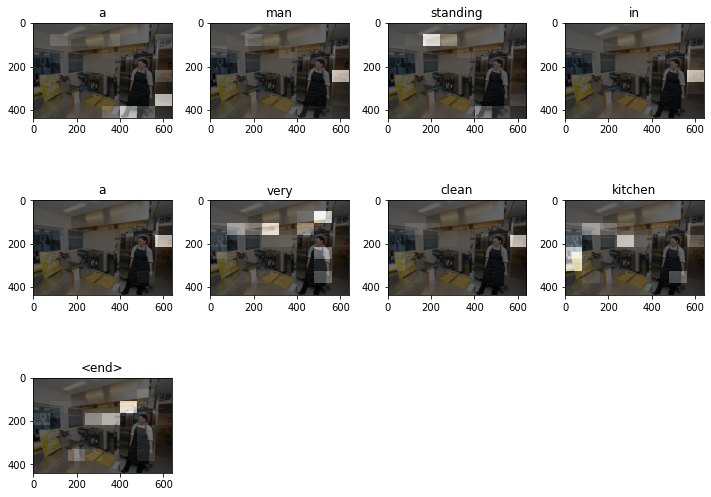

In [ ]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Prediction Caption: a woman in a bathroom with a microwave oven <end>


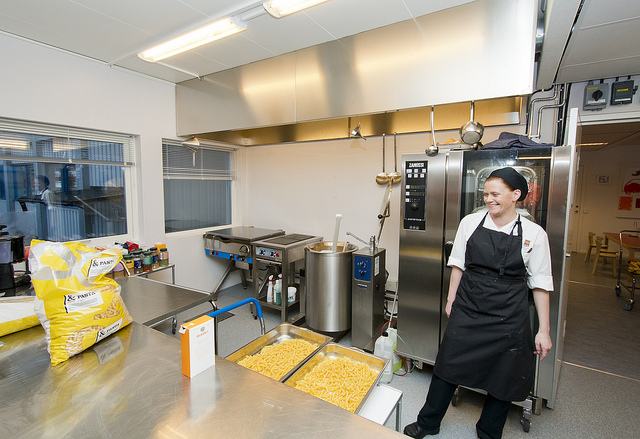

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]


result, attention_plot = evaluate(image)
print('Prediction Caption:', ' '.join(result))
#plot_attention(img_path, result, attention_plot)
Image.open(image)

## 7. Conclusion et retour sur le modèle

Pour conclure ce livrable, nous sommes à présent capable de faire de l'annotation d'image basé sur un modèle associant CNN pré-entraîné avec ImageNet et RNN utilisé avec tokenization. Comme nous avons pu le voir, les performances sont acceptables mais largement améliorables. Pour améliorer ce modèle, nous pourrons :

1.   Augmenter le volume des données
2.   Varier les données du dataset
3.   Entraîner notre modèle avec d'autres datasets
4.   Utiliser des LSTM au lieu des GRU pour le RNN, car le LSTM sera certes plus gourmant en temps et en ressources, mais il performera mieux que le GRU
5.   Entraîner notre modèle sur plus d'epochs, avec Early-Stopping
6.   Implémenter d'autres méthodes de régularisation




